# Memory latency tests

We measured idle and loaded latencies for local, remote NUMA socket and CXL memory 
with the following setup.

### CPU

```sh
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         52 bits physical, 57 bits virtual
  Byte Order:            Little Endian
CPU(s):                  384
  On-line CPU(s) list:   0-383
Vendor ID:               AuthenticAMD
  BIOS Vendor ID:        Advanced Micro Devices, Inc.
  Model name:            AMD EPYC 9654 96-Core Processor
    BIOS Model name:     AMD EPYC 9654 96-Core Processor                 Unknown
                          CPU @ 2.4GHz
    BIOS CPU family:     107
    CPU family:          25
    Model:               17
    Thread(s) per core:  2
    Core(s) per socket:  96
    Socket(s):           2
    Stepping:            1
    Frequency boost:     enabled
    CPU(s) scaling MHz:  41%
    CPU max MHz:         3707.8120
    CPU min MHz:         1500.0000
    BogoMIPS:            4799.99
    Flags: ...

Virtualization features: 
  Virtualization:        AMD-V
Caches (sum of all):     
  L1d:                   6 MiB (192 instances)
  L1i:                   6 MiB (192 instances)
  L2:                    192 MiB (192 instances)
  L3:                    768 MiB (24 instances)
NUMA:                    
  NUMA node(s):          3
  NUMA node0 CPU(s):     0-95,192-287
  NUMA node1 CPU(s):     96-191,288-383
  NUMA node2 CPU(s):     
...
```

### Memory
2 numa nodes DDR5 x12 channels (each node)

### CXL memory 
CXL device is attached as headless NUMA node 2.

- size: 126GB
- channels?

```sh
drovelli9@Hardanger:~$ lspci -s 7f:00.0 -vv
7f:00.0 CXL: PMC-Sierra Inc. Device 8702 (rev 01) (prog-if 10 [CXL Memory Device (CXL 2.x)])
	Subsystem: PMC-Sierra Inc. Device 0000
	Control: I/O- Mem+ BusMaster- SpecCycle- MemWINV- VGASnoop- ParErr- Stepping- SERR- FastB2B- DisINTx-
	Status: Cap+ 66MHz- UDF- FastB2B- ParErr- DEVSEL=fast >TAbort- <TAbort- <MAbort- >SERR- <PERR- INTx-
	IOMMU group: 11
	Region 0: Memory at 74c6c100000 (64-bit, prefetchable) [size=256K]
	Capabilities: <access denied>
	Kernel driver in use: cxl_pci
	Kernel modules: cxl_pci
```

### VM
We use QEMU 7.2.0 and Ubuntu 24.04. We emulate the same host memory configuration in the VM:

```sh
qemu-system-x86_64 \
-machine q35 \
-cpu host \
-smp 33 \
--enable-kvm \
-object memory-backend-ram,size=16G,host-nodes=0,policy=bind,prealloc=on,id=local-mem \
-object memory-backend-ram,size=16G,host-nodes=1,policy=bind,prealloc=on,id=remote-mem \
-object memory-backend-ram,size=16G,host-nodes=2,policy=bind,prealloc=on,id=cxl-mem \
-m 48G,slots=3,maxmem=64G \
-numa node,nodeid=0,memdev=local-mem \
-numa node,nodeid=1,memdev=remote-mem \
-numa node,nodeid=2,memdev=cxl-mem \
-drive if=virtio,file=cxlvm2_disk.qcow2,cache=none \
-net nic,macaddr=52:54:00:12:34:02 \
-net user,hostfwd=tcp::2223-:22 \
-nographic
```

### Benchmark
Intel MLC v3.12 with 32 threads.

For the loaded latencies on numa node 0 on 32 cores (local in our setup): 
```sh
./mlc --loaded_latency -j0 -k1-33
```

For idle latency matrix (all numa nodes): 
```sh
./mlc --latency_matrix
```


In [46]:
import numpy as np
import matplotlib.pyplot as plt

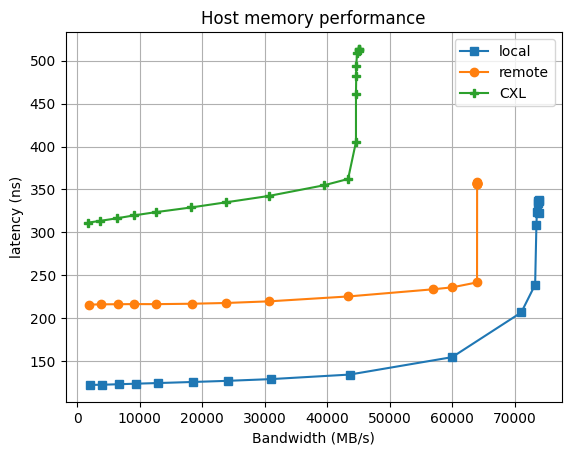

In [47]:
# load host vals

hlocal = np.loadtxt("host/loaded_local.txt",skiprows=3)
hremote = np.loadtxt("host/loaded_remote.txt",skiprows=3)
hcxl = np.loadtxt("host/loaded_cxl.txt",skiprows=3)

# plot
fig, ax = plt.subplots()

ax.set_title("Host memory performance")
ax.set_xlabel("Bandwidth (MB/s)")
ax.set_ylabel("latency (ns)")

ax.plot(hlocal[:,2],hlocal[:,1],'-s',label="local")
ax.plot(hremote[:,2],hremote[:,1],'-o',label="remote")
ax.plot(hcxl[:,2],hcxl[:,1],'-P',label="CXL")

ax.legend()
ax.grid()

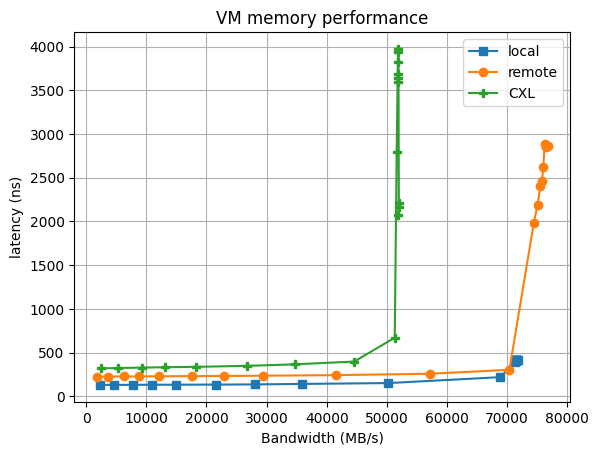

In [48]:
# load host vals

vmlocal = np.loadtxt("vm/loaded_local.txt",skiprows=3)
vmremote = np.loadtxt("vm/loaded_remote2.txt",skiprows=3)
vmcxl = np.loadtxt("vm/loaded_cxl3.txt",skiprows=3)

# plot
fig, ax = plt.subplots()

ax.set_title("VM memory performance")
ax.set_xlabel("Bandwidth (MB/s)")
ax.set_ylabel("latency (ns)")

ax.plot(vmlocal[:,2],vmlocal[:,1],'-s',label="local")
ax.plot( vmremote[:,2],vmremote[:,1],'-o',label="remote")
ax.plot(vmcxl[:,2],vmcxl[:,1],'-P',label="CXL")

ax.legend()
ax.grid()

# Analysis

Remote and CXL memory have unexpected performance in VMs: they reach higher bandwidth
than the correspoding phyisical memories. A possible explaination is that Intel MLC
struggles to balance maximum throughput when executed in VMs, going over maximum capacity hence 
resulting in very high latency peaks since the bandwidth is oversaturated. It can be observed
that latency values return to normal after they fall into the physical badwidth range.